APPENDIX 2: ADVANCED DQN: DOUBLE AND Deuling


Base code taken from https://github.com/Curt-Park/rainbow-is-all-you-need with adaptations from https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/DeepQLearning, and https://www.youtube.com/watch?v=WHRQUZrxxGw&t=4786s

In [ ]:
#importing the libraries
from torch.cuda import random
!pip install Box2D
import os
from typing import Dict, List, Tuple
import math

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import randint
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

!pip install box2d-py
!pip install gym[all]
!pip install gym[Box_2D]
!pip install git+https://github.com/ngc92/space-wrappers.git
!pip install "ray[rllib]"==1.6

import gym
import space_wrappers


from torch import randint
import random
from random import sample, random

from collections import deque,namedtuple
from typing import Any
from random import sample, random

from dataclasses import dataclass
from ray import tune
import numpy as np
import ray.rllib.agents.dqn as dqn

In [46]:
#Create the replay buffer
class ReplayBuffer:

    def __init__(self, obs_dim, size, batch_size = 32):
        self.observations = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_observations = np.zeros([size, obs_dim], dtype=np.float32)
        self.actions_buffer = np.zeros([size], dtype=np.float32)
        self.rewards_buffer = np.zeros([size], dtype=np.float32)
        self.done_buffer = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(self,observation,action, reward, next_observation, done):
        self.observations[self.ptr] = observation
        self.next_observations[self.ptr] = next_observation
        self.actions_buffer[self.ptr] = action
        self.rewards_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(observations=self.observations[idxs],
                    next_observations=self.next_observations[idxs],
                    action=self.actions_buffer[idxs],
                    reward=self.rewards_buffer[idxs],
                    done=self.done_buffer[idxs])

    def __len__(self) -> int:
        return self.size


#Create Network

class Network(nn.Module):
    def __init__(self, states_in, actions_out):
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(states_in, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, actions_out)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

#Double - DQN Agent

class Double_DQNAgent:

    def __init__(self, env ,memory_size, batch_size, target_update, epsilon_decay, max_epsilon = 1.0, min_epsilon= 0.1, gamma = 0.99,):

        observations_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(observations_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(observations_dim, action_dim).to(self.device)
        self.dqn_target = Network(observations_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        #store tranisitions in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state):
        #epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action):
        #action -> next_state, reward, done
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self):
        #update model
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        #trick gradient clipping:
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames, plotting_interval = 100):
        #train agent
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            #end episode
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            #buffer if filled for training
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # epsilon decay
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # update target network
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder):
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state = self.env.reset()
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples):
        device = self.device 
        state = torch.FloatTensor(samples["observations"]).to(device)
        next_state = torch.FloatTensor(samples["next_observations"]).to(device)
        action = torch.LongTensor(samples["action"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["reward"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        #current Q network decides which one is the best next action a’ among all the available next actions, 
        #and then the target neural network evaluates this action to know its Q-value.
        curr_q_value = self.dqn(state).gather(1, action)
        #Double DQN
        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate the dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss
    
    def _target_hard_update(self):
        #Update target network
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(self, frame_idx, scores, losses, epsilons,):
        #plot train
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()



In [47]:
# parameters
env = gym.make('LunarLander-v2')
num_frames = 30_000
memory_size = 1000
batch_size = 32
target_update = 200
epsilon_decay = 1 / 2000

# train
agent_double = Double_DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


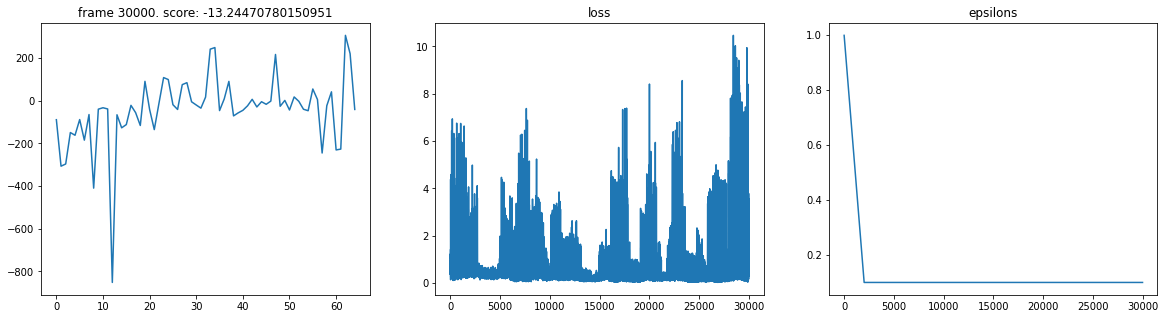

In [48]:
agent_double.train(num_frames)


Dueling DQN: The steps are similar than above except we have a different Neurel network and compute loss function.

In [49]:
class Network(nn.Module):
    def __init__(self, states_in, actions_out):
        """Initialization."""
        super(Network, self).__init__()

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(states_in, 128), 
            nn.ReLU(),
        )
        
        ##advantage function for each action a =  (A(s, a))
        self.advantage_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, actions_out),
        )

        #state value function for state s =  (V(s))
        self.value_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x) -> torch.Tensor:
        feature = self.feature_layer(x)
        
        value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)

        # infinitely many solutions so trick to make problem identifiable
        # we take mean
        q = value + advantage - advantage.mean(dim=-1, keepdim=True)
        
        return q

#Double - DQN Agent

class Duelling_DQNAgent:

    def __init__(self, env ,memory_size, batch_size, target_update, epsilon_decay, max_epsilon = 1.0, min_epsilon= 0.1, gamma = 0.99,):

        observations_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(observations_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(observations_dim, action_dim).to(self.device)
        self.dqn_target = Network(observations_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        #store tranisitions in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state):
        #epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action):
        #action -> next_state, reward, done
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self):
        #update model
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        #trick gradient clipping:
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames, plotting_interval = 100):
        #train agent
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            #end episode
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            #buffer if filled for training
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # epsilon decay
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # update target network
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder):
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state = self.env.reset()
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env

    #Duelling
    def _compute_dqn_loss(self, samples):
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["observations"]).to(device)
        next_state = torch.FloatTensor(samples["next_observations"]).to(device)
        action = torch.LongTensor(samples["action"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["reward"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)


        curr_q_value = self.dqn(state).gather(1, action)
        #duelling
        next_q_value = self.dqn_target(next_state).max( 
            dim=1, keepdim=True
        )[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss
    
    def _target_hard_update(self):
        #Update target network
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(self, frame_idx, scores, losses, epsilons,):
        #plot train
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

In [50]:
env = gym.make('LunarLander-v2')
num_frames = 30_000
memory_size = 1000
batch_size = 32
target_update = 200
epsilon_decay = 1 / 2000

# train
agent_duelling = Duelling_DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


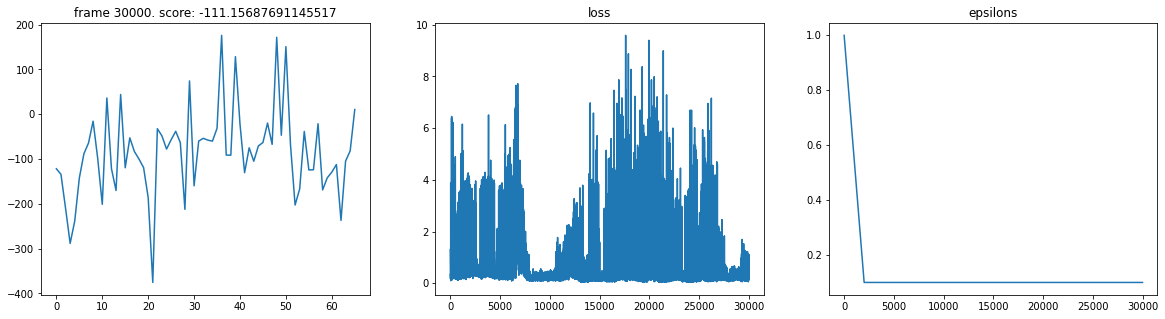

In [51]:
agent_duelling.train(num_frames)
